In [1]:
# --- Step 1: Libraries and data loading ---
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# خواندن فایل داده‌ها
data = pd.read_excel(r"C:\Users\Win 10\Documents\aberham\Abraham_Viscosity_Model_with_vs.xlsx")

# حذف ردیف‌های ناقص
data = data.dropna(subset=['x1', 'vs1', 'vs2', 't', 'vsm']).reset_index(drop=True)

# اطمینان از نوع عددی بودن
cols_to_num = ['x1', 'vs1', 'vs2', 't', 'vsm']
for c in cols_to_num:
    data[c] = pd.to_numeric(data[c], errors='coerce')

print(f"✅ Data loaded successfully. Shape: {data.shape}")
data.head()


✅ Data loaded successfully. Shape: (5467, 19)


,solvent1,solvent2,x1,t,vs1,vs2,c1,e1,s1,a1,b1,v1,c2,e2,s2,a2,b2,v2,vsm
0,[4bmpy][Tf2N],[emim][EtSO4],0.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01221
1,[4bmpy][Tf2N],[emim][EtSO4],1.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00706
2,[4bmpy][Tf2N],[emim][EtSO4],0.7740,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01008
3,[4bmpy][Tf2N],[emim][EtSO4],0.6659,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01168
4,[4bmpy][Tf2N],[emim][EtSO4],0.8823,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00868


In [5]:
# --- Step 2: Define the Jouyban–Acree model (Eq. 8) up to i=2 ---
def jouyban_acree_model(x, J0, J1, J2):
    """
    Jouyban–Acree model:
    ln(η_mix) = x1*ln(η1) + x2*ln(η2) + x1*x2 * [J0 + J1*(x1 - x2) + J2*(x1 - x2)**2]
    """
    x1, eta1, eta2 = x
    x2 = 1 - x1
    return x1*np.log(eta1) + x2*np.log(eta2) + x1*x2*(J0 + J1*(x1 - x2) + J2*(x1 - x2)**2)


In [6]:
# --- Step 3: Fit Jouyban–Acree model for the entire dataset ---
xdata = (data['x1'].values, data['vs1'].values, data['vs2'].values)
ydata = np.log(data['vsm'].values)

# مقداردهی اولیه ضرایب
initial_guess = [0.0, 0.0, 0.0]

# برازش مدل با scipy.optimize.curve_fit
popt, pcov = curve_fit(jouyban_acree_model, xdata, ydata, p0=initial_guess, maxfev=10000)
J0, J1, J2 = popt

print("✅ Fitted Jouyban–Acree parameters:")
print(f"J0 = {J0:.4f},  J1 = {J1:.4f},  J2 = {J2:.4f}")


✅ Fitted Jouyban–Acree parameters:
J0 = 1.8670,  J1 = -1.6258,  J2 = 1.0748


📈 Jouyban–Acree model performance:
R² = 0.8952, RMSE = 0.0214, MAPE = 22.38%


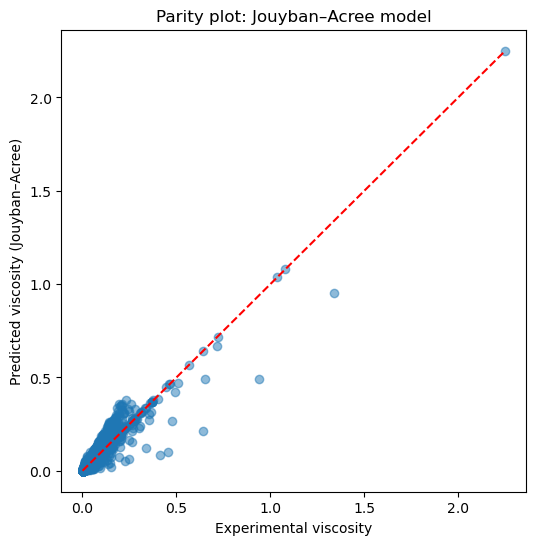

In [7]:
# --- Step 4: Compare experimental and fitted values ---
data['ln_vsm_pred'] = jouyban_acree_model(xdata, *popt)
data['vsm_pred'] = np.exp(data['ln_vsm_pred'])

# محاسبه خطاها
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
r2 = r2_score(data['vsm'], data['vsm_pred'])
rmse = np.sqrt(mean_squared_error(data['vsm'], data['vsm_pred']))
mape = mean_absolute_percentage_error(data['vsm'], data['vsm_pred']) * 100

print(f"📈 Jouyban–Acree model performance:")
print(f"R² = {r2:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.2f}%")

# نمودار
plt.figure(figsize=(6,6))
plt.scatter(data['vsm'], data['vsm_pred'], alpha=0.5)
plt.plot([data['vsm'].min(), data['vsm'].max()], [data['vsm'].min(), data['vsm'].max()], 'r--')
plt.xlabel("Experimental viscosity")
plt.ylabel("Predicted viscosity (Jouyban–Acree)")
plt.title("Parity plot: Jouyban–Acree model")
plt.show()


In [8]:
# --- Step 5: Correlate J parameters with Abraham parameters ---
features = ['c1','e1','s1','a1','b1','v1','c2','e2','s2','a2','b2','v2']
X = data[features]
y_J0 = np.full(len(X), J0)
y_J1 = np.full(len(X), J1)
y_J2 = np.full(len(X), J2)

# ایجاد DataFrame برای تحلیل بیشتر
J_df = pd.DataFrame({
    'J0': y_J0, 'J1': y_J1, 'J2': y_J2
})
print("✅ Created J-parameter dataset.")
J_df.head()


✅ Created J-parameter dataset.


,J0,J1,J2
0,1.866976,-1.625756,1.074848
1,1.866976,-1.625756,1.074848
2,1.866976,-1.625756,1.074848
3,1.866976,-1.625756,1.074848
4,1.866976,-1.625756,1.074848


In [9]:
# --- Step 6: Jouyban–Acree model with temperature dependence (Eq. 9) ---

def jouyban_acree_temp_model(x, A0, B0, A1, B1, A2, B2):
    """
    ln(η_mix) = x1*ln(η1) + x2*ln(η2) + x1*x2 * [(A0 + B0/T) + (A1 + B1/T)*(x1 - x2) + (A2 + B2/T)*(x1 - x2)**2]
    """
    x1, eta1, eta2, T = x
    x2 = 1 - x1
    term = (A0 + B0/T) + (A1 + B1/T)*(x1 - x2) + (A2 + B2/T)*(x1 - x2)**2
    return x1*np.log(eta1) + x2*np.log(eta2) + x1*x2*term

# آماده‌سازی داده‌ها
xdata_T = (data['x1'].values, data['vs1'].values, data['vs2'].values, data['t'].values)
ydata = np.log(data['vsm'].values)

# مقداردهی اولیه ضرایب (۶ پارامتر)
initial_guess_T = [0, 0, 0, 0, 0, 0]

# برازش مدل
popt_T, pcov_T = curve_fit(jouyban_acree_temp_model, xdata_T, ydata, p0=initial_guess_T, maxfev=20000)
A0, B0, A1, B1, A2, B2 = popt_T

print("✅ Fitted temperature-dependent Jouyban–Acree parameters:")
print(f"A0={A0:.4f}, B0={B0:.4f}, A1={A1:.4f}, B1={B1:.4f}, A2={A2:.4f}, B2={B2:.4f}")


✅ Fitted temperature-dependent Jouyban–Acree parameters:
A0=1.3638, B0=158.7791, A1=0.5656, B1=-691.1556, A2=-0.1491, B2=385.8652


📈 Temperature-dependent Jouyban–Acree model performance:
R² = 0.8918, RMSE = 0.0218, MAPE = 22.38%


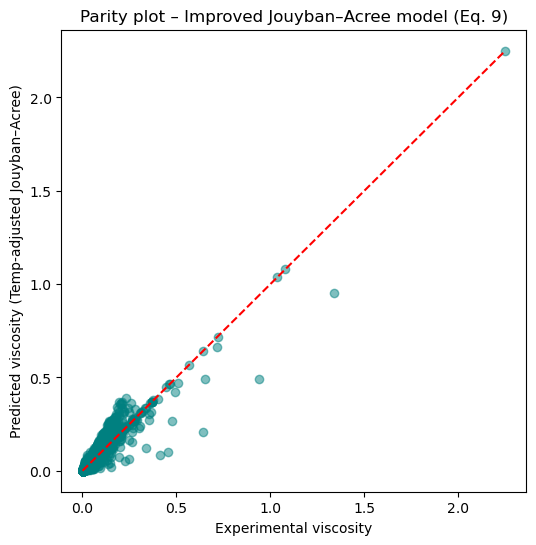

In [10]:
# --- Step 7: Evaluate improved Jouyban–Acree model ---
data['ln_vsm_pred_T'] = jouyban_acree_temp_model(xdata_T, *popt_T)
data['vsm_pred_T'] = np.exp(data['ln_vsm_pred_T'])

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

r2_T = r2_score(data['vsm'], data['vsm_pred_T'])
rmse_T = np.sqrt(mean_squared_error(data['vsm'], data['vsm_pred_T']))
mape_T = mean_absolute_percentage_error(data['vsm'], data['vsm_pred_T']) * 100

print(f"📈 Temperature-dependent Jouyban–Acree model performance:")
print(f"R² = {r2_T:.4f}, RMSE = {rmse_T:.4f}, MAPE = {mape_T:.2f}%")

# نمودار جدید
plt.figure(figsize=(6,6))
plt.scatter(data['vsm'], data['vsm_pred_T'], alpha=0.5, color='teal')
plt.plot([data['vsm'].min(), data['vsm'].max()],
         [data['vsm'].min(), data['vsm'].max()], 'r--')
plt.xlabel("Experimental viscosity")
plt.ylabel("Predicted viscosity (Temp-adjusted Jouyban–Acree)")
plt.title("Parity plot – Improved Jouyban–Acree model (Eq. 9)")
plt.show()


In [11]:
# Cell 1: imports and paths
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# If you want to use a small neural net
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Paths (adjust if needed)
data_path = r"C:\Users\Win 10\Documents\aberham\Abraham_Viscosity_Model_with_vs.xlsx"
results_dir = r"C:\Users\Win 10\Documents\aberham\jouyban_abraham_ml_results"
os.makedirs(results_dir, exist_ok=True)

print("✅ Libraries imported and results directory:", results_dir)


✅ Libraries imported and results directory: C:\Users\Win 10\Documents\aberham\jouyban_abraham_ml_results


In [12]:
# Cell 2: read data and basic cleaning
df = pd.read_excel(data_path)
# Keep only rows with required columns
required_cols = ['solvent1','solvent2','x1','t','vs1','vs2','vsm',
                 'c1','e1','s1','a1','b1','v1','c2','e2','s2','a2','b2','v2']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in data file: {missing}")

# Drop rows with missing numeric values
df = df.dropna(subset=['x1','t','vs1','vs2','vsm']).reset_index(drop=True)

# Convert numeric columns
num_cols = ['x1','t','vs1','vs2','vsm'] + ['c1','e1','s1','a1','b1','v1','c2','e2','s2','a2','b2','v2']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop any rows that became NaN
df = df.dropna(subset=num_cols).reset_index(drop=True)

print("Data shape after cleaning:", df.shape)
df.head()


Data shape after cleaning: (5467, 19)


,solvent1,solvent2,x1,t,vs1,vs2,c1,e1,s1,a1,b1,v1,c2,e2,s2,a2,b2,v2,vsm
0,[4bmpy][Tf2N],[emim][EtSO4],0.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01221
1,[4bmpy][Tf2N],[emim][EtSO4],1.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00706
2,[4bmpy][Tf2N],[emim][EtSO4],0.7740,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01008
3,[4bmpy][Tf2N],[emim][EtSO4],0.6659,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01168
4,[4bmpy][Tf2N],[emim][EtSO4],0.8823,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00868


In [13]:
# Cell 3: compute K and delta_x
# ln units: using natural log as in Jouyban–Acree implementation before
df['x2'] = 1.0 - df['x1']
# avoid division by zero in rare x1==0 or x1==1 rows; drop them
df = df[(df['x1']>0) & (df['x1']<1)].reset_index(drop=True)

df['ln_eta1'] = np.log(df['vs1'])
df['ln_eta2'] = np.log(df['vs2'])
df['ln_vsm'] = np.log(df['vsm'])

df['K_effective'] = (df['ln_vsm'] - (df['x1']*df['ln_eta1'] + df['x2']*df['ln_eta2'])) / (df['x1']*df['x2'])
df['delta_x'] = df['x1'] - df['x2']

# Quick stats
print("K_effective stats:")
print(df['K_effective'].describe())

# save intermediate dataset
df.to_excel(os.path.join(results_dir, "jouyban_intermediate_K_dataset.xlsx"), index=False)
print("✅ Saved intermediate dataset with K to:", os.path.join(results_dir, "jouyban_intermediate_K_dataset.xlsx"))


K_effective stats:
count    4491.000000
mean        2.248547
std         2.966198
min        -3.784242
25%         0.462092
50%         1.722610
75%         2.950288
max        72.937040
Name: K_effective, dtype: float64
✅ Saved intermediate dataset with K to: C:\Users\Win 10\Documents\aberham\jouyban_abraham_ml_results\jouyban_intermediate_K_dataset.xlsx


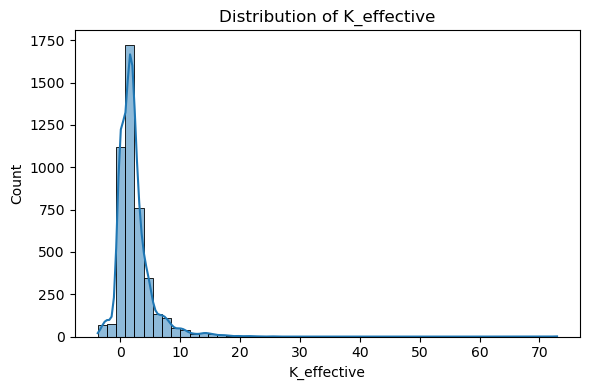

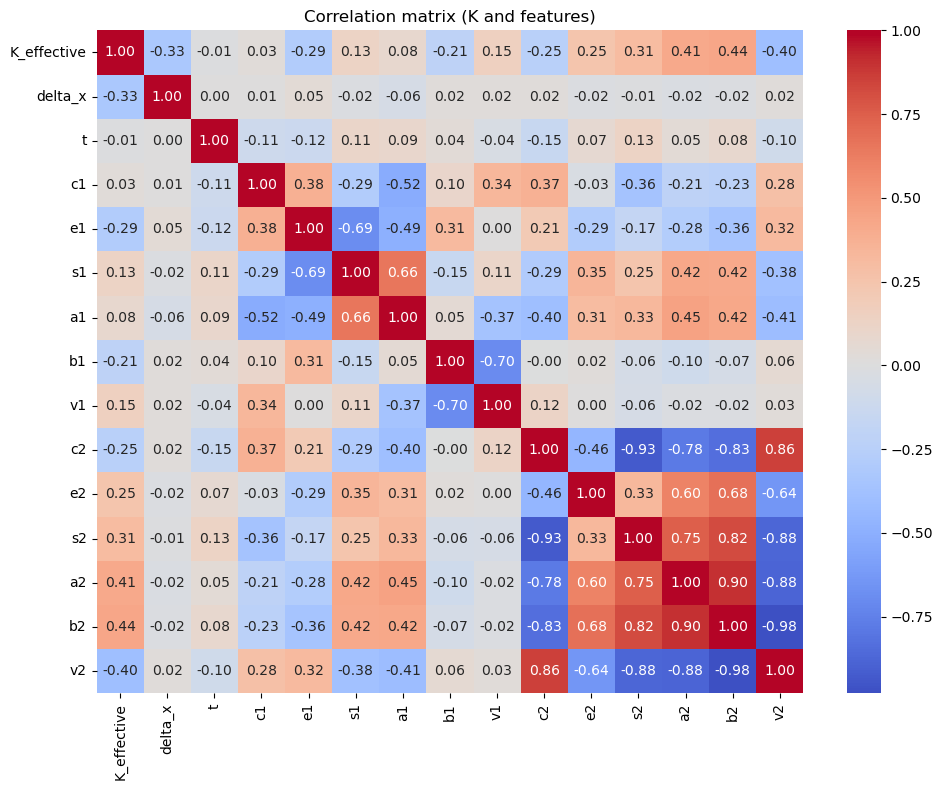

In [15]:
# Cell 4: EDA - distribution and correlations
plt.figure(figsize=(6,4))
sns.histplot(df['K_effective'], bins=50, kde=True)
plt.title("Distribution of K_effective")
plt.xlabel("K_effective")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "K_distribution.png"), dpi=300)
plt.show()

# Correlation of K with some Abraham features
corr_features = ['K_effective','delta_x','t','c1','e1','s1','a1','b1','v1','c2','e2','s2','a2','b2','v2']
corrmat = df[corr_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrmat, center=0, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation matrix (K and features)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "K_correlation_matrix.png"), dpi=300)
plt.show()


In [16]:
# Cell 5: prepare features and target for ML (predict K)
features = ['delta_x','t','c1','e1','s1','a1','b1','v1','c2','e2','s2','a2','b2','v2']
X = df[features].copy()
y = df['K_effective'].copy()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling numeric features (fit scaler on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# save scaler
joblib.dump(scaler, os.path.join(results_dir, "scaler_K.pkl"))
print("✅ Prepared training and testing sets and saved scaler.")


✅ Prepared training and testing sets and saved scaler.


In [17]:
# Cell 6: MLR for K
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
y_mlr_pred = mlr.predict(X_test_scaled)
r2_mlr = r2_score(y_test, y_mlr_pred)
rmse_mlr = sqrt(mean_squared_error(y_test, y_mlr_pred))
mape_mlr = mean_absolute_percentage_error(y_test, y_mlr_pred)*100

print("MLR for K -> R2: {:.4f}, RMSE: {:.5f}, MAPE: {:.2f}%".format(r2_mlr, rmse_mlr, mape_mlr))

# save model
joblib.dump(mlr, os.path.join(results_dir, "MLR_K_model.pkl"))


MLR for K -> R2: 0.5372, RMSE: 1.85282, MAPE: 807.85%


['C:\\Users\\Win 10\\Documents\\aberham\\jouyban_abraham_ml_results\\MLR_K_model.pkl']

In [18]:
# Cell 7: Random Forest for K
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # RF can take unscaled X, but scaler used earlier; here using raw features
y_rf_pred = rf.predict(X_test)
r2_rf = r2_score(y_test, y_rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, y_rf_pred))
mape_rf = mean_absolute_percentage_error(y_test, y_rf_pred)*100

print("RF for K -> R2: {:.4f}, RMSE: {:.5f}, MAPE: {:.2f}%".format(r2_rf, rmse_rf, mape_rf))
joblib.dump(rf, os.path.join(results_dir, "RF_K_model.pkl"))


RF for K -> R2: 0.4868, RMSE: 1.95101, MAPE: 39.23%


['C:\\Users\\Win 10\\Documents\\aberham\\jouyban_abraham_ml_results\\RF_K_model.pkl']

In [19]:
# Cell 8: SVR for K (may be slower)
svr = SVR(kernel='rbf', C=10, gamma='scale')
# Note: SVR needs scaled inputs
svr.fit(X_train_scaled, y_train)
y_svr_pred = svr.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_svr_pred)
rmse_svr = sqrt(mean_squared_error(y_test, y_svr_pred))
mape_svr = mean_absolute_percentage_error(y_test, y_svr_pred)*100

print("SVR for K -> R2: {:.4f}, RMSE: {:.5f}, MAPE: {:.2f}%".format(r2_svr, rmse_svr, mape_svr))
joblib.dump(svr, os.path.join(results_dir, "SVR_K_model.pkl"))


SVR for K -> R2: 0.8851, RMSE: 0.92304, MAPE: 63.90%


['C:\\Users\\Win 10\\Documents\\aberham\\jouyban_abraham_ml_results\\SVR_K_model.pkl']

In [20]:
# Cell 9: Simple NN for K using Keras
def build_small_nn(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

nn = build_small_nn(X_train_scaled.shape[1])
es = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)
history = nn.fit(X_train_scaled, y_train, validation_split=0.15, epochs=300, batch_size=64, callbacks=[es], verbose=0)

# predict
y_nn_pred = nn.predict(X_test_scaled).flatten()
r2_nn = r2_score(y_test, y_nn_pred)
rmse_nn = sqrt(mean_squared_error(y_test, y_nn_pred))
mape_nn = mean_absolute_percentage_error(y_test, y_nn_pred)*100

print("NN for K -> R2: {:.4f}, RMSE: {:.5f}, MAPE: {:.2f}%".format(r2_nn, rmse_nn, mape_nn))
# save model
nn.save(os.path.join(results_dir, "NN_K_model.h5"))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


NN for K -> R2: 0.9212, RMSE: 0.76460, MAPE: 119.93%


In [21]:
# Cell 10: compare and save K predictions
results_K = pd.DataFrame({
    'y_test': y_test,
    'y_mlr_pred': y_mlr_pred,
    'y_rf_pred': y_rf_pred,
    'y_svr_pred': y_svr_pred,
    'y_nn_pred': y_nn_pred
}, index=y_test.index)

# compute metrics summary
def summary_metrics(y_true, y_pred):
    return {'R2': r2_score(y_true, y_pred),
            'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
            'MAPE_pct': mean_absolute_percentage_error(y_true, y_pred)*100}

summary = pd.DataFrame({
    'MLR': summary_metrics(y_test, y_mlr_pred),
    'RF': summary_metrics(y_test, y_rf_pred),
    'SVR': summary_metrics(y_test, y_svr_pred),
    'NN': summary_metrics(y_test, y_nn_pred)
}).T

print(summary)
summary.to_excel(os.path.join(results_dir, "K_models_summary.xlsx"))
results_K.to_excel(os.path.join(results_dir, "K_models_predictions.xlsx"))
print("✅ Saved K model summaries and predictions to results folder.")


           R2      RMSE    MAPE_pct
MLR  0.537184  1.852816  807.854072
RF   0.486827  1.951014   39.231553
SVR  0.885136  0.923039   63.898016
NN   0.921185  0.764597  119.931901
✅ Saved K model summaries and predictions to results folder.


In [22]:
# Cell 11: reconstruct viscosity using predicted K (choose best model, e.g., RF or NN)
# Here we will reconstruct using RF and NN predictions and save both

# Align test index to original df rows
test_idx = y_test.index

# For RF predictions (rf was trained on raw X), need X_test rows accordingly
K_pred_rf = results_K.loc[test_idx, 'y_rf_pred'].values
K_pred_nn = results_K.loc[test_idx, 'y_nn_pred'].values
K_pred_svr = results_K.loc[test_idx, 'y_svr_pred'].values
K_pred_mlr = results_K.loc[test_idx, 'y_mlr_pred'].values

# reconstruct ln_eta_mix_pred = x1*ln_eta1 + x2*ln_eta2 + x1*x2 * K_pred
reconstructions = []
for model_name, Kpred in [('MLR',K_pred_mlr), ('RF',K_pred_rf), ('SVR',K_pred_svr), ('NN',K_pred_nn)]:
    sel = df.loc[test_idx, :].copy()
    sel['K_pred'] = Kpred
    sel['ln_eta_pred_recon'] = sel['x1']*sel['ln_eta1'] + sel['x2']*sel['ln_eta2'] + sel['x1']*sel['x2']*sel['K_pred']
    sel['eta_pred_recon'] = np.exp(sel['ln_eta_pred_recon'])
    # compute metrics vs experimental vsm
    r2_recon = r2_score(sel['vsm'], sel['eta_pred_recon'])
    rmse_recon = sqrt(mean_squared_error(sel['vsm'], sel['eta_pred_recon']))
    mape_recon = mean_absolute_percentage_error(sel['vsm'], sel['eta_pred_recon'])*100
    print(f"{model_name} reconstruction -> R2: {r2_recon:.4f}, RMSE: {rmse_recon:.4f}, MAPE: {mape_recon:.2f}%")
    sel.to_excel(os.path.join(results_dir, f"reconstructed_eta_{model_name}.xlsx"), index=False)
    reconstructions.append((model_name, r2_recon, rmse_recon, mape_recon))

# Save summary
recon_df = pd.DataFrame(reconstructions, columns=['model','R2_recon','RMSE_recon','MAPE_recon'])
recon_df.to_excel(os.path.join(results_dir, "reconstruction_summary.xlsx"), index=False)
print("✅ Saved reconstructed viscosity results and summary.")


MLR reconstruction -> R2: 0.9304, RMSE: 0.0121, MAPE: 19.78%
RF reconstruction -> R2: 0.9986, RMSE: 0.0017, MAPE: 2.84%
SVR reconstruction -> R2: 0.9961, RMSE: 0.0029, MAPE: 4.46%
NN reconstruction -> R2: 0.9924, RMSE: 0.0040, MAPE: 6.19%
✅ Saved reconstructed viscosity results and summary.


In [23]:
# Cell 12: save useful artifacts: scaler, trained models (already saved), and the full df with K
df.to_excel(os.path.join(results_dir, "jouyban_full_with_K.xlsx"), index=False)

# Save summary of J parameters from global fit earlier (if you have popped values)
# If you ran global fit earlier and have A0,B0... you can save them like:
try:
    global_params = {
        'A0': A0, 'B0': B0, 'A1': A1, 'B1': B1, 'A2': A2, 'B2': B2
    }
    pd.Series(global_params).to_excel(os.path.join(results_dir, "global_Jouyban_params.xlsx"))
    print("✅ Saved global Jouyban temperature-dependent parameters.")
except NameError:
    print("Global Jouyban params not found in this session; skip saving them.")

print("All artifacts saved in:", results_dir)


✅ Saved global Jouyban temperature-dependent parameters.
All artifacts saved in: C:\Users\Win 10\Documents\aberham\jouyban_abraham_ml_results


In [3]:
import pandas as pd

path = r"C:\Users\Win 10\Documents\aberham\Abraham_Viscosity_Model_with_vs.xlsx"

df = pd.read_excel(path)

print(df.shape)
df.head()


(5467, 19)


,solvent1,solvent2,x1,t,vs1,vs2,c1,e1,s1,a1,b1,v1,c2,e2,s2,a2,b2,v2,vsm
0,[4bmpy][Tf2N],[emim][EtSO4],0.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01221
1,[4bmpy][Tf2N],[emim][EtSO4],1.0000,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00706
2,[4bmpy][Tf2N],[emim][EtSO4],0.7740,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01008
3,[4bmpy][Tf2N],[emim][EtSO4],0.6659,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.01168
4,[4bmpy][Tf2N],[emim][EtSO4],0.8823,293.15,0.00706,0.01221,-0.216,0.269,0.559,-1.668,-3.937,3.394,-0.124,-0.013,0.582,-0.976,-4.941,2.924,0.00868


In [4]:
df.columns


Index(['solvent1', 'solvent2', 'x1', 't', 'vs1', 'vs2', 'c1', 'e1', 's1', 'a1',
       'b1', 'v1', 'c2', 'e2', 's2', 'a2', 'b2', 'v2', 'vsm'],
      dtype='object')

In [5]:
import numpy as np

x1 = df['x1']
x2 = 1 - x1

for p in ['a','b','s','e','v']:
    if f'{p}_avg' not in df.columns:
        df[f'{p}_avg']  = x1*df[f'{p}1'] + x2*df[f'{p}2']
        df[f'{p}_diff'] = np.abs(df[f'{p}1'] - df[f'{p}2'])


In [6]:
# ==========================================
# Compute K (Jouyban–Acree interaction term)
# ==========================================

import numpy as np

x1 = df['x1']
x2 = 1 - x1

df['K'] = (
    np.log(df['vsm'])
    - x1*np.log(df['vs1'])
    - x2*np.log(df['vs2'])
) / (x1*x2)

print(df['K'].describe())


count    4496.000000
mean             NaN
std              NaN
min             -inf
25%         0.462608
50%         1.723163
75%         2.951538
max              inf
Name: K, dtype: float64


C:\Users\Win 10\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [7]:
# ==========================================
# Remove pure-component limits (x1=0 or 1)
# ==========================================

df_K = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['K'])

print("Original size:", df.shape[0])
print("Valid K size :", df_K.shape[0])

df_K['K'].describe()


Original size: 5467
Valid K size : 4491


count    4491.000000
mean        2.248547
std         2.966198
min        -3.784242
25%         0.462092
50%         1.722610
75%         2.950288
max        72.937040
Name: K, dtype: float64

In [8]:
# ==========================================
# Inputs / Output for K-learning
# ==========================================

# delta x
df_K['dx'] = df_K['x1'] - (1 - df_K['x1'])

feature_cols = [
    'a_avg','b_avg','s_avg','e_avg','v_avg',
    'a_diff','b_diff','s_diff','e_diff','v_diff',
    'dx','t'
]

X = df_K[feature_cols].values
y = df_K['K'].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (4491, 12)
y shape: (4491,)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# نگه داشتن ایندکس
X_df = df_K[feature_cols]
y_s  = df_K['K']

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_s, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)


(3592, 12) (899, 12)


In [15]:
# ==========================================
# Neural Network for K-learning (FINAL)
# ==========================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation='relu',
          kernel_regularizer=l2(1e-4),
          input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),

    Dense(32, activation='relu',
          kernel_regularizer=l2(1e-4)),
    Dropout(0.2),

    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/500


C:\Users\Win 10\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12.4793 - val_loss: 4.2803
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8177 - val_loss: 3.5066
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1142 - val_loss: 3.1101
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7502 - val_loss: 2.8017
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4318 - val_loss: 2.6466
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0442 - val_loss: 2.5327
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1263 - val_loss: 2.4839
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9952 - val_loss: 2.3371
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7169 - val_loss: 2.2726
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7885 - val_loss: 2.1866
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7956 - val_loss: 2.1659
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8992 - val_l

In [16]:
# ==========================================
# Evaluation of K prediction
# ==========================================

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

K_test_pred = model.predict(X_test_scaled).ravel()

R2_K = r2_score(y_test, K_test_pred)
RMSE_K = np.sqrt(mean_squared_error(y_test, K_test_pred))

print(f"R2 (K)   = {R2_K:.3f}")
print(f"RMSE (K) = {RMSE_K:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R2 (K)   = 0.895
RMSE (K) = 0.8805


In [17]:
# ==========================================
# Reconstruct ln(viscosity_mix) from K_pred
# ==========================================

# ایندکس‌های تست
test_idx = X_test.index

# مول‌فرکشن‌ها
x1_t = df_K.loc[test_idx, 'x1']
x2_t = 1 - x1_t

# بازسازی ln(viscosity)
ln_eta_pred = (
    x1_t * np.log(df_K.loc[test_idx, 'vs1']) +
    x2_t * np.log(df_K.loc[test_idx, 'vs2']) +
    x1_t * x2_t * K_test_pred
)

ln_eta_true = np.log(df_K.loc[test_idx, 'vsm'])

R2_rec = r2_score(ln_eta_true, ln_eta_pred)
RMSE_rec = np.sqrt(mean_squared_error(ln_eta_true, ln_eta_pred))

print(f"Reconstructed R2   = {R2_rec:.3f}")
print(f"Reconstructed RMSE = {RMSE_rec:.4f}")


Reconstructed R2   = 0.992
Reconstructed RMSE = 0.1200


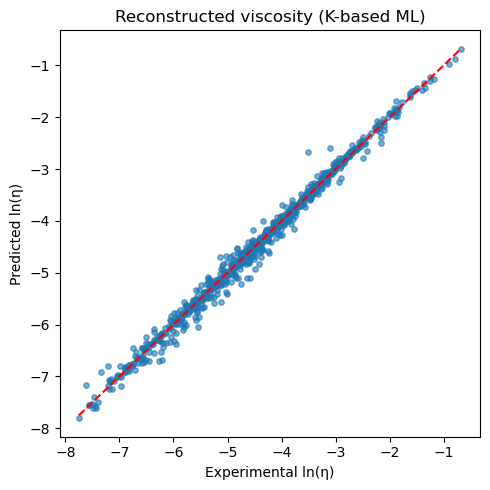

In [18]:
# ==========================================
# Parity plot for reconstructed viscosity
# ==========================================

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(ln_eta_true, ln_eta_pred, s=15, alpha=0.6)
plt.plot([ln_eta_true.min(), ln_eta_true.max()],
         [ln_eta_true.min(), ln_eta_true.max()],
         'r--')
plt.xlabel("Experimental ln(η)")
plt.ylabel("Predicted ln(η)")
plt.title("Reconstructed viscosity (K-based ML)")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut


In [20]:
# solvent identifier (pair-wise symmetric)
df['solvent_pair'] = df.apply(
    lambda r: '-'.join(sorted([str(r['solvent1']), str(r['solvent2'])])),
    axis=1
)

unique_solvents = df['solvent_pair'].unique()
print("Number of unique solvent systems:", len(unique_solvents))


Number of unique solvent systems: 85


In [21]:
# ===============================
# Cell 3 — Jouyban–Acree (K-model)
# ===============================

feature_cols = [
    'a_avg','b_avg','s_avg','e_avg','v_avg',
    'a_diff','b_diff','s_diff','e_diff','v_diff',
    'x1','t'
]

X_all = df[feature_cols]
y_all = df['K']   # target = interaction term


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

results = []

n_total = len(unique_solvents)
print(f"Total solvent systems: {n_total}")

for i, solvent in enumerate(unique_solvents, start=1):

    print(f"LOOS {i}/{n_total} → {solvent}")

    train_mask = df['solvent_pair'] != solvent
    test_mask  = df['solvent_pair'] == solvent

    X_train = X_all.loc[train_mask].values
    y_train = y_all.loc[train_mask].values

    X_test  = X_all.loc[test_mask].values
    y_test  = y_all.loc[test_mask].values

    # ---- Remove NaN / Inf ----
    valid_train = np.isfinite(y_train)
    valid_test  = np.isfinite(y_test)

    X_train = X_train[valid_train]
    y_train = y_train[valid_train]

    X_test  = X_test[valid_test]
    y_test  = y_test[valid_test]

    # safety checks
    if len(y_test) < 2 or len(y_train) < 20:
        print("  ⚠ skipped (insufficient valid data)")
        continue

    # ---- Model ----
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    model.fit(
        X_train, y_train,
        epochs=80,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(
            monitor='loss',
            patience=15,
            restore_best_weights=True
        )]
    )

    y_pred = model.predict(X_test, verbose=0).ravel()

    r2   = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'solvent': solvent,
        'R2': r2,
        'RMSE': rmse,
        'n_test': len(y_test)
    })


Total solvent systems: 85
LOOS 1/85 → [4bmpy][Tf2N]-[emim][EtSO4]
LOOS 2/85 → [bmim][BF4]-[bpy][BF4]
LOOS 3/85 → [Bmim][BF4]-methanol
LOOS 4/85 → [Bmim][BF4]-acetone
LOOS 5/85 → DMF-[Bmim][BF4]
LOOS 6/85 → [BMIM][BF4]-dimethyl sulfox
LOOS 7/85 → [BMIM][BF4]-ethylene glycol
LOOS 8/85 → [BMIM][BF4]-water
LOOS 9/85 → [BMIM][CF3SO3]-water
LOOS 10/85 → PC-[bmim][NTf2]
LOOS 11/85 → Ethanol-[Bmim][NTf2]
LOOS 12/85 → [BMIM][NTf2]-methanol
LOOS 13/85 → DMSO-[BMIM][NTf2]
LOOS 14/85 → [bmim][CF3SO3]-[bmim][PF6]
LOOS 15/85 → [BMIM][PF6]-dimethyl sulfox
LOOS 16/85 → [BMIM][PF6]-methanol
LOOS 17/85 → [BMIM][PF6]-tetrahydrofuran
LOOS 18/85 → [BMIM][SCN]-water
LOOS 19/85 → 1-butanol-[BMIM][SCN]
LOOS 20/85 → 1-hexanol-[BMIM][SCN]
LOOS 21/85 → 1-pentanol-[BMIM][SCN]
LOOS 22/85 → [BMPIP][DCA]-water
LOOS 23/85 → [BMPIP][SCN]-water
LOOS 24/85 → [BMPy][SCN]-water
LOOS 25/85 → [BMPYR][DCA]-water
LOOS 26/85 → [BMPYR][SCN]-water
LOOS 27/85 → [4bmpy][Tf2N]-[bpy][BF4]
LOOS 28/85 → [BPY][BF4]-[BPY][Tf2N]
LOOS 29/

In [26]:
df_results = pd.DataFrame(results)

print("Average LOOS performance:")
print("R2   =", df_results['R2'].mean())
print("RMSE =", df_results['RMSE'].mean())

df_results.sort_values('R2').head()


Average LOOS performance:
R2   = -268.0129575123289
RMSE = 1.833514214575424


,solvent,R2,RMSE,n_test
34,[C4C1im][SCN]-benzen,-20163.848454,3.366687,16
1,[bmim][BF4]-[bpy][BF4],-1348.049202,0.562025,99
29,[C2C1im][NTf2]-benzene,-239.704291,1.325566,16
33,[C4C1im][CF3SO3-benzene,-170.156200,0.925111,16
13,[bmim][CF3SO3]-[bmim][PF6],-125.961263,1.864929,152
